(sec_guide_abc)=
# An ABC analysis

This page shows how to do an Abstract Bayesian Computation (ABC) analysis,
where the discriminator output is used as a measure of similarity
to the target dataset.
* We'll continue to use the two-parameter
  bottleneck model from the [](sec_guide_creating_a_dinf_model) page.
* Dinf saves the discriminator predictions as a [numpy `.npz`](numpy:numpy.save)
  file, which we'll load back into Python for exploratory analysis.
* We'll also plot the results with the `dinf-plot` command.

The results below were obtained using 80 Xeon 6248 CPU cores for simulations,
and a Tesla T4 GPU for training and applying the neural network.

## Training the discriminator

Using the `dinf train` subcommand, we'll train the
discriminator on 1 million training replicates, with 20,000 test replicates.
This will train the discriminator on 500,000
samples from the generator (with parameter values sampled from the prior
distribution) and 500,000 samples from the target dataset
(using the `truth` parameter values, as this is a simulation-only model).

In [1]:
%%bash
mkdir -p out/abc
rm -f out/abc/bottleneck.nn
time dinf train \
    --epochs 20 \
    --training-replicates 1000000 \
    --test-replicates 20000 \
    --model ../../examples/bottleneck/model.py \
    --discriminator out/abc/bottleneck.nn

Generator/train ━━━━━━━━━━━━ 500000/500000   0:00:00                            
Target/train    ━━━━━━━━━━━━ 500000/500000   0:00:00                            
Generator/test  ━━━━━━━━━━━━ 10000/10000     0:00:00                            
Target/test     ━━━━━━━━━━━━ 10000/10000     0:00:00                            
Epoch           ━━━━━━━━━━━━ 20/20           0:00:00                            
 Train          ━━━━━━━━━━━━ 1000000/1000000 0:00:00 loss 0.0133 accuracy 0.9961
 Test           ━━━━━━━━━━━━ 20000/20000     0:00:00 loss 0.0214 accuracy 0.9936



real	28m46.978s
user	1131m55.561s
sys	72m34.477s


The output `.nn` file is the trained discriminator, which contains the trained
network's weights and some additional metadata such as the loss and accuracy.

In [2]:
%%bash
dinf-plot metrics \
    --output-file /tmp/metrics.svg \
    out/abc/bottleneck.nn

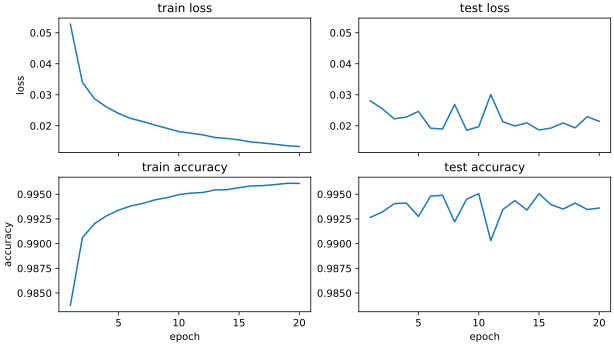

In [3]:
from IPython.display import SVG, display

display(SVG(filename="/tmp/metrics.svg"))

## Sampling from the prior and measuring similarity

Next, we'll use the `predict` subcommand to obtain discriminator predictions
for 1 million replicates from the generator (with parameter values sampled
from the prior).


In [5]:
%%bash
rm -f out/abc/bottleneck.npz
time dinf predict \
    --replicates 1000000 \
    --model ../../examples/bottleneck/model.py \
    --discriminator out/abc/bottleneck.nn \
    --output-file out/abc/bottleneck.npz

Generator ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1000000/1000000 0:00:00
Predict   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1000000/1000000 0:00:00



real	21m42.130s
user	1581m24.244s
sys	64m1.751s


The output file is an uncompressed [numpy `.npz`](numpy:numpy.save) file.
This file contains the parameter values for each replicate, and the predictions
made by the discriminator. It can be loaded back into Python using the
[`dinf.load_results()`](dinf.load_results) function.

In [6]:
import dinf

data = dinf.load_results("out/abc/bottleneck.npz")
# The returned data is a numpy structured array.
data[:5]

array([(6.4720407e-25, 28068.66004508, 13206.24622337),
       (1.6651894e-12, 20915.40349848,   936.94013519),
       (2.4685076e-23, 25215.90569126,  4731.54557225),
       (1.0584644e-24, 29853.60094112, 15835.29214881),
       (2.4895346e-08, 13594.90440328,  5200.88017331)],
      dtype=[('_Pr', '<f4'), ('N0', '<f8'), ('N1', '<f8')])

In [7]:
# Columns correspond to the distinct parameters, and the
# special column "_Pr" contains the discriminator predictions.
data.dtype.names

('_Pr', 'N0', 'N1')

The discriminator outputs the probability that
a given input feature is from the target distribution, so we would like
the probabilities to be clustered around 0 for parameters that are
far from the true values and clustered around 1 for parameters that are
close to the true values. But note that the discriminator output will
depend on the extent of the parameter space used in training.
I.e. if the discriminator is trained on a parameter space that is just
a small neighbourhood around the true parameter values,
then the discriminator will have a hard time distinguishing the two
datasets and thus produce few values near 0 or 1.
On the other hand, the discriminator might actually be too good
because of [model misspecification](sec_guide_misspecification),
in which case there will be many values near 0 and few near 1.

To see how much of our parameter space is being classified as coming
from the target dataset, lets plot the distribution of probabilities
(the `_Pr` column) as a histogram. We'll use `dinf-plot` with the `hist`
subcommand.


In [8]:
%%bash
dinf-plot hist \
    --x-param _Pr \
    --output-file /tmp/hist-Pr.svg \
    out/abc/bottleneck.npz

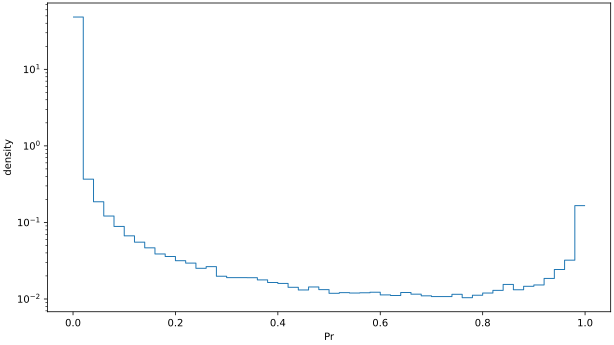

In [9]:
from IPython.display import SVG, display

display(SVG(filename=f"/tmp/hist-Pr.svg"))

## Choosing the posterior distribution

For a rejection ABC, two simple ways of choosing the posterior distribution are
- choose the $n$ samples with the highest discriminator score, or
- choose samples with a score $>x$.

Below, we'll take the top 1000 samples and look at the median value
and a 95% interval for this posterior sample.

In [10]:
import dinf
import numpy as np

data = dinf.load_results("out/abc/bottleneck.npz")

# Predictions from discriminator.
probs = data["_Pr"]
# Get the indices that sort the probabilities in ascending order.
idx = np.flip(np.argsort(data["_Pr"]))
# Posterior sample for parameters N0 and N1.
posterior = data[idx[:1_000]]

# Print median values and 95% credible intervals.
for par in ("N0", "N1"):
    lo, median, hi = np.quantile(posterior[par], [0.025, 0.5, 0.975])
    print(par, median, (lo, hi))

N0 10255.658265365973 (7228.2277269071365, 14323.751889852982)
N1 217.44741361044572 (75.72906853160343, 656.5670985337933)


Recall that the `truth` values used in the model were `N0=10000`
and `N1=200`. The 95% credible intervals contain these values,
and the median values are close to the `truth`.
Note that the accuracy of the discriminator could potentially
be further improved (see [](sec_guide_accuracy)), which would
presumably lead to narrower confidence intervals and/or median
values even closer to the truth.

## Tabulating the results
Manually loading the results and doing the rejection sampling
is not actually necessary. The `dinf-tabulate` command has a
`quantiles` subcommand that outputs data quantiles.
The default behaviour is to calculate the 0.025, 0.5, 0.975 quantiles,
and print them as tab-separated values.
The data may be filtered to take the top $n$ samples,
as we did previously.

In [17]:
%%bash
dinf-tabulate quantiles \
    --top 1000 \
    out/abc/bottleneck.npz

Param	0.025	0.5	0.975
N0	7228.2277269071365	10255.658265365973	14323.751889852982
N1	75.72906853160343	217.44741361044572	656.5670985337933


## Plotting the results
For a visual summary of the posterior, we can use `dinf-plot hist`
to plot histograms of the data.
The dark blue stepped line is the histogram,
the smooth light blue line is a kernel density estimate,
the red vertical line indicates the truth value,
and the black bar shows the median (50% marker)
and 95% credible intervals (2.5% and 97.5% markers).


In [12]:
%%bash
dinf-plot hist \
    --top 1000 \
    --kde \
    --model ../../examples/bottleneck/model.py \
    --output-file /tmp/hist-abc-top-1000.svg \
    out/abc/bottleneck.npz

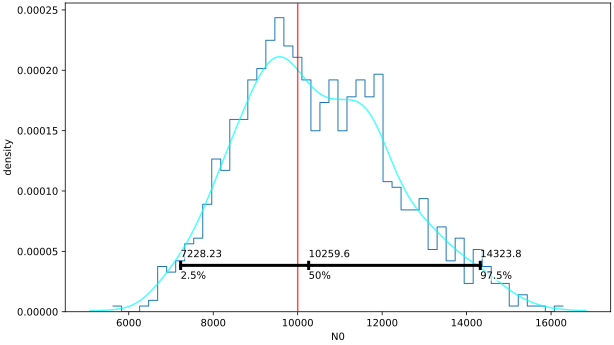

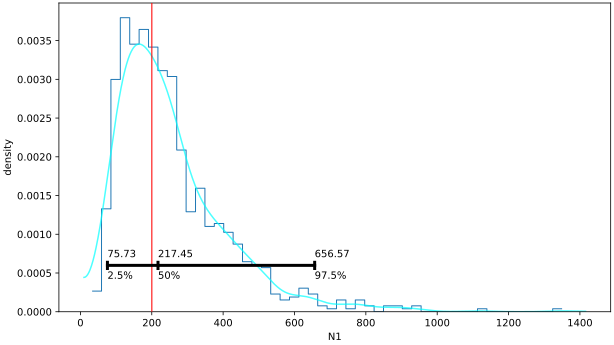

In [13]:
from IPython.display import SVG, display

for par in ("N0", "N1"):
    display(SVG(filename=f"/tmp/hist-abc-top-1000_{par}.svg"))

Finally, we'll use the `hist2d` subcommand to show both `N0` and `N1` jointly.

In [15]:
%%bash
dinf-plot hist2d \
    --top 1000 \
    --model ../../examples/bottleneck/model.py \
    --output-file /tmp/hist2d-abc-top-1000.svg  \
    out/abc/bottleneck.npz

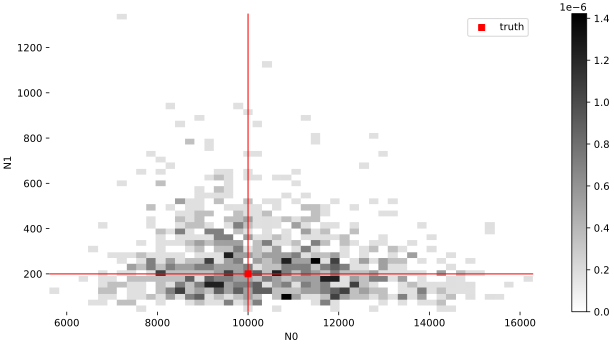

In [16]:
from IPython.display import SVG, display

display(SVG(filename="/tmp/hist2d-abc-top-1000.svg"))